# Import Libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import requests 
import re
import nltk
from nltk import sent_tokenize
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text,sequence
import collections
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM,Embedding
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D ,Dropout
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Bidirectional, LSTM
from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Dropout
from keras.layers import Concatenate



# Read The Data

In [2]:
 df = pd.read_csv("Toner_updatedDisNew4.csv")
df.head(8)

,Unnamed: 0,tag,patterns,responses
0,0,hardwarenewton,my printer capabl print document,ok you want order new toner lnk what kind color
1,1,hardwarenewton,my printer print paper,ok you want order new toner lnk what kind color
2,2,hardwarenewton,i think lnk empti,ok you want order new toner lnk what kind color
3,3,hardwarenewton,i believ lnk empti,ok you want order new toner lnk what kind color
4,4,hardwarenewton,the lnk appear empti,ok you want order new toner lnk what kind color
5,5,hardwarenewton,i believ lnk unfil,ok you want order new toner lnk what kind color
6,6,hardwarenewton,my printer toner cartridg,ok you want order new toner lnk what kind color
7,7,hardwarenewton,my printer toner,ok you want order new toner lnk what kind color


In [3]:
#drob the Unnamed column 
df.drop('Unnamed: 0',
axis='columns', inplace=True)


In [4]:
#creat new column
df['Class'] = df['tag'].map({' catagorysoftwar ':0,' hardwarenewprint ':1,'hardwarenewton':2,' subcatagorysoftwar ':3,' hardwarenewprinterjustif ':4,' subjectnewemail ':5,'hardwarenewtonercolor':6, ' greet ':7, ' thank ':8, ' name ':9, ' goodby ':"10" , ' item ':11, ' location2 ':12,' contactinformation2 ':13, ' location3 ':14, ' contact information3 ':15, 'hardwarenewtonerisdnam':16,' contact information1 ':17, 'hardwarenewtonerprintermodel':18, ' location1 ':19})

In [5]:
df.sample(10)

,tag,patterns,responses,Class
222,hardwarenewprinterjustif,i want print document printer,ok problem give inform pleas name,4
267,name,ahmad alharthi,ok extens number pleas,9
175,hardwarenewprint,it would great i new printer offic,ok sure justif order printer,1
135,subcatagorysoftwar,a softwar applic need uninstal,ok i need contact inform pleas name,3
201,hardwarenewprinterjustif,i need printer sinc i one,ok problem give inform pleas name,4
96,catagorysoftwar,we problem softwar,what kind softwar issu have,0
48,hardwarenewtonercolor,i d want black lnk,your order toner record jest i want ask isd n...,6
221,hardwarenewprinterjustif,the paper i need print need print printer,ok problem give inform pleas name,4
191,hardwarenewprint,a new printer need offic,ok sure justif order printer,1
245,subjectnewemail,i m brandnew employe email address,fine what item need depart email user email em...,5


# Stop words from english library in general 

In [6]:
y = df["patterns"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["patterns"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)


# Word Frequencies

In [7]:
patterns= df.patterns.str.cat(sep=' ')
patterns

' my printer capabl print document   my printer print paper   i think lnk empti   i believ lnk empti   the lnk appear empti   i believ lnk unfil   my printer toner cartridg   my printer toner   my printer lnk   my printer lack lnk   my lnk empti   my toner empti   i want order new lnk   i d want order new lnk   i want order new toner   i want order new black lnk   i want order new black toner   i want request new toner   i d like request replac toner cartridg   i d want order new toner cartridg   i toner cartridg printer   there toner cartridg printer   i can not use printer toner cartridg empti   a toner cartridg printer   my printer lack toner cartridg   it toner cartridg   the toner cartridg printer empti   the printer toner cartridg  â€œ i want black lnk â€\u200c  i want black toner   i would like black lnk   black lnk i need   it would nice black lnk   pleas send black lnk   it s black lnk i want   black color   i need color   i need color   all color need   i need color   i need 

# Word Tokenize

In [8]:
tokens = word_tokenize(patterns)

vocabulary = set(tokens)
print(len(vocabulary))

frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:20]

174


['i',
 'printer',
 'softwar',
 'new',
 'need',
 'offic',
 'email',
 'want',
 'the',
 'my',
 'problem',
 'work',
 'lnk',
 'toner',
 'black',
 'would',
 'pleas',
 'one',
 'there',
 'm']

# Embeddings with multiword ngrams

In [9]:

def top_n_words(corpus, n=None):
# هنا ابدا اسوي يونيقرام للباترنز باي كاونت 
    cv = CountVectorizer(stop_words= stopwords.words("english")).fit(corpus) 
    bag_of_words = cv.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = top_n_words(df['patterns'], 25)
for word, count in common_words:
    
    print(word, count)
df_unigrams = pd.DataFrame(common_words,columns = ['word' , 'count'])
df_unigrams.head(30)

printer 95
softwar 79
new 56
need 55
offic 43
email 26
want 25
problem 20
work 20
lnk 19
toner 19
black 17
would 16
pleas 16
one 16
applic 15
address 15
like 12
cartridg 11
instal 11
open 10
uninstal 10
program 9
get 9
print 8


,word,count
0,printer,95
1,softwar,79
2,new,56
3,need,55
4,offic,43
5,email,26
6,want,25
7,problem,20
8,work,20
9,lnk,19


# B-igrams

In [10]:
def top_n_words(corpus, n=None):
    cv = CountVectorizer(stop_words= stopwords.words("english"),ngram_range=(2, 2)).fit(corpus)
    bag_of_words = cv.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = top_n_words(df['patterns'], 20)

df_bigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_bigrams.head(10)


,word,count
0,new printer,33
1,printer offic,25
2,email address,15
3,softwar applic,12
4,need new,12
5,toner cartridg,11
6,problem softwar,11
7,softwar work,11
8,black lnk,10
9,get new,8


# Tigram 

In [11]:
def top_n_words(corpus, n=None):
    vect = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vect.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = top_n_words(df['patterns'],20)
#for word, count in common_words:
    
    #print(word, count)
df_trigram = pd.DataFrame(common_words, columns = ['word' , 'count'])
df_trigram.head(20)

,word,count
0,new printer offic,16
1,need new printer,8
2,new email address,7
3,want order new,6
4,get new printer,6
5,there problem softwar,5
6,the softwar work,5
7,toner cartridg printer,4
8,is possibl printer,4
9,possibl printer offic,4


In [12]:
sentences = df.iloc[19] # how can i choose randomly sentences ?
sentences['patterns']
print (nltk.sent_tokenize(sentences['patterns']))
print('___________Convert sentences into words________________')
print (nltk.word_tokenize(sentences['patterns']))

[' i d want order new toner cartridg']
___________Convert sentences into words________________
['i', 'd', 'want', 'order', 'new', 'toner', 'cartridg']


In [13]:
#Bag of word 
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()
count_vector.fit(df['patterns'])

CountVectorizer()

# Document Matrix

In [14]:

doc_array = count_vector.transform(df['patterns'][:10]).toarray()
doc_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
frequency_matrix = pd.DataFrame(doc_array,index=df['patterns'][:10],columns=count_vector.get_feature_names())
frequency_matrix.head()

,access,account,address,ahmad,alharthi,alkhathran,all,almutairi,alqahtani,alsufyani,...,want,way,we,wish,without,work,workplac,would,yellow,you
patterns,,,,,,,,,,,,,,,,,,,,,
my printer capabl print document,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
my printer print paper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i think lnk empti,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i believ lnk empti,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
the lnk appear empti,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


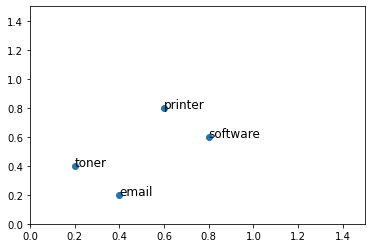

In [16]:

words = ['printer','software', 'toner', 'email']  

vectors = np.array([[0.6,   0.8], 
                    [0.8, 0.6],
                   [.2,.4],[.4,.2]]
                 ) 

plt.plot(vectors[:,0], vectors[:,1], 'o')  
plt.xlim(0, 1.5)  
plt.ylim(0, 1.5)  
for word, x, y in zip(words, vectors[:,0], vectors[:,1]):  
    plt.annotate(word, (x, y), size=12)

# TF_IDF

In [17]:
frequency_matrix = pd.DataFrame(doc_array,index=df['patterns'][:10],columns=count_vector.get_feature_names())
frequency_matrix.head()

,access,account,address,ahmad,alharthi,alkhathran,all,almutairi,alqahtani,alsufyani,...,want,way,we,wish,without,work,workplac,would,yellow,you
patterns,,,,,,,,,,,,,,,,,,,,,
my printer capabl print document,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
my printer print paper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i think lnk empti,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i believ lnk empti,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
the lnk appear empti,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Word2vec

In [18]:

r = (df)

shelley_text = r.patterns

print(shelley_text[:100])


0      my printer capabl print document 
1                my printer print paper 
2                     i think lnk empti 
3                    i believ lnk empti 
4                  the lnk appear empti 
                     ...                
95                              it work 
96                   we problem softwar 
97                       softwar broken 
98                     i troubl softwar 
99                there problem softwar 
Name: patterns, Length: 100, dtype: object


In [19]:
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(df.patterns))

In [20]:
mystring = "&lrm;Some Time W&zwnj;e"
mystring  = re.sub(r"&lrm;", "", mystring)
mystring  = re.sub(r"&zwnj;", "", mystring)

In [21]:
df['patterns1']=df['patterns'].apply(str)

In [22]:
# Next, we'll pre-process the text by adding periods where
# weant sentence breaks to occur.

# replace 2 or more new lines with a period and one new line
shelley_text = re.sub(r"\n{2,}", ".  ", str(shelley_text))

# replace single new lines with a space
shelley_text = re.sub(r"\n", " ", str(shelley_text))
print(shelley_text[:300])

0       my printer capabl print document  1                 my printer print paper  2                      i think lnk empti  3                     i believ lnk empti  4                   the lnk appear empti                        ...                 273                                 badg  274   


In [23]:
# Now we're going to use NLTK's sentence tokenizer to split the text into sentences. Be careful! The sentence tokenizer is sensitive to preprocessing steps like lowercasing text.


nltk.download('punkt')

sentences = sent_tokenize(shelley_text)

sentences = sentences[2:]

print(f"We found {len(sentences)} sentences!", end="\n\n")

for sent in sentences[:2]:
    print(sentences[:200], end="\n\n")

We found 0 sentences!



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssq12\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 # Bag Of Words

In [24]:
count_vector = CountVectorizer()
count_vector.fit(df['patterns'])

CountVectorizer()

In [25]:
# the next step uses CountVectorizer to build a sentence vocabulary

countvect = CountVectorizer(max_features=2500)

bow = countvect.fit_transform(df.patterns)

 # Word2vec

In [26]:
import gensim

#Dimension of vectors we are generating
EMBEDDING_DIM = 10

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X,window=2, min_count=1)
#vocab size
len(w2v_model.wv)



146

In [27]:


model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [28]:
max_text_length=11
max_features=100 

x_tokenizer=Tokenizer(max_features)
y_tokenizer=Tokenizer(max_features)


# Models

# Long Short Term Memory

In [40]:
X=df['patterns'].values
y=df['Class'].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print('Training Data:', X_train.shape[0])
print('Test Data:', X_test.shape[0])

Training Data: 222
Test Data: 56


In [41]:
max_features=100
max_text_length=11
x_tokenizer=Tokenizer(max_features)

y_tokenizer=Tokenizer(max_features)

In [42]:
x_tokenizer.fit_on_texts(X)
word_index = x_tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 174 unique tokens.


In [48]:
import collections 
max_features=100
max_text_length=11


x_tokenizer=Tokenizer(max_features)
y_tokenizer=Tokenizer(max_features)


In [49]:
print('Top 5 most common words are:', collections.Counter(x_tokenizer.word_counts).most_common(5))

Top 5 most common words are: []


In [ ]:
model.save('LSTM.h5') 

# 1. Training a Simple RNN from Scratch

In [51]:

seq_len = 11 # standardized length of each word sequence 
max_vocab = 15000 # max number of words to consider when tokenizing (based on freq)

# fit tokenizer vocab (note that it lowercases and strips punct)
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(df.patterns)

# standard train/val split
X_train, X_test, y_train, y_test = train_test_split(df.patterns, df.Class, 
                                                    test_size=0.2, random_state = 42)

# multiclass output formatting
y_train_cat = np_utils.to_categorical(y_train)

# convert train and val texts to token sequences of standardized length 50,
# padding fills leading 0s in or cuts off sequence at 50th word
X_train = tokenizer.texts_to_sequences(X_train) 
X_train = pad_sequences(X_train, maxlen=seq_len)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=seq_len)

In [52]:


embedding_dim = 40 # hyper-parameter 

inp = Input(shape=(seq_len,)) # must specify format of input layer
x = Embedding(max_vocab, embedding_dim)(inp) # model learns its own word embeddings
x = Bidirectional(LSTM(32, recurrent_dropout=.3))(x) # bi-LSTM with regularization
x = Dense(32)(x)
y = Dense(19, activation='softmax')(x)

NN = Model(inp, y)
NN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 embedding (Embedding)       (None, 11, 40)            600000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               18688     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 19)                627       
                                                                 
Total params: 621,395
Trainable params: 621,395
Non-trainable params: 0
_______________________________________________________

In [53]:
NN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = NN.fit(X_train, y_train_cat, 
                 validation_split=.2,
                 epochs=10, batch_size=512, verbose=1)

Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 2.9509 - accuracy: 0.0113 - val_loss: 2.9408 - val_accuracy: 0.0667
Epoch 2/10
1/1 [==============================] - 0s 58ms/step - loss: 2.9399 - accuracy: 0.0734 - val_loss: 2.9316 - val_accuracy: 0.0889
Epoch 3/10
1/1 [==============================] - 0s 88ms/step - loss: 2.9290 - accuracy: 0.1186 - val_loss: 2.9223 - val_accuracy: 0.1333
Epoch 4/10
1/1 [==============================] - 0s 100ms/step - loss: 2.9180 - accuracy: 0.1356 - val_loss: 2.9130 - val_accuracy: 0.1556
Epoch 5/10
1/1 [==============================] - 0s 83ms/step - loss: 2.9069 - accuracy: 0.1525 - val_loss: 2.9033 - val_accuracy: 0.1778
Epoch 6/10
1/1 [==============================] - 0s 89ms/step - loss: 2.8953 - accuracy: 0.1921 - val_loss: 2.8932 - val_accuracy: 0.2000
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 2.8832 - accuracy: 0.2542 - val_loss: 2.8826 - val_accuracy: 0.2667
Epoch 8/10
1/1 [============

## 2. Training an RNN with Transferred Word Embeddings

In [54]:
word_index = tokenizer.word_index

# change the path to point to your pretrained google vectors file
w2v_file = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'

# load the w2v vectors using gensim
word_vectors = KeyedVectors.load_word2vec_format(w2v_file, binary=True)

embedding_dim = 300 # w2v embedding dim

# use the gensim model to build a numpy array of embeddings,
# we'll feed this array to the keras embeddings layer.
# each row i of the array will correspond to the word token assigned to that value 
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except: # word in our data vocab is missing in w2v, will use 0 vector for that word
        pass

In [55]:

embedding_dim = 300

inp = Input(shape=(seq_len,))
x = Embedding(len(word_index) + 1,
              embedding_dim,
              weights=[embedding_matrix], # where we feed the pretrained vecs
              trainable=False)(inp) # freeze these parameters in the model

x = Bidirectional(LSTM(256, recurrent_dropout = .3))(x)
x = Dense(128, activation='relu')(x) # fully connected layer on top of the output of the bi-LSTM
x = Dropout(.3)(x)
y = Dense(19, activation='softmax')(x)

NN = Model(inp, y)
NN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 11)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 11, 300)           52500     
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1140736   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 19)                2451      
                                                           

In [65]:
NN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN.fit(X_train, y_train_cat, 
       validation_split=.2,
       epochs=5, batch_size=512, verbose=1)

Epoch 1/5
1/1 [==============================] - 12s 12s/step - loss: 0.3562 - accuracy: 0.9096 - val_loss: 0.7263 - val_accuracy: 0.7556
Epoch 2/5
1/1 [==============================] - 0s 410ms/step - loss: 0.3841 - accuracy: 0.8531 - val_loss: 0.6434 - val_accuracy: 0.8222
Epoch 3/5
1/1 [==============================] - 0s 406ms/step - loss: 0.3519 - accuracy: 0.8757 - val_loss: 0.6085 - val_accuracy: 0.8222
Epoch 4/5
1/1 [==============================] - 0s 403ms/step - loss: 0.2840 - accuracy: 0.9209 - val_loss: 0.6367 - val_accuracy: 0.8444
Epoch 5/5
1/1 [==============================] - 0s 401ms/step - loss: 0.2620 - accuracy: 0.9153 - val_loss: 0.7091 - val_accuracy: 0.7778


## Best accuracy: 0.9209

In [66]:
model.save('LSTM_RNN_with_Transferred_Word_Embeddings.h5') 

## 3. Extension: Training an RNN with Both Custom and Transferred Word Embeddings

In [57]:

embedding_dim_pre = 300
embedding_dim_custom = 40

inp = Input(shape=(seq_len,))
emb_pre = Embedding(len(word_index) + 1,
                    embedding_dim_pre,
                    weights=[embedding_matrix], # where we feed the pretrained vecs
                    trainable=False)(inp) # freeze these parameters in the model

emb_cus = Embedding(max_vocab, embedding_dim_custom)(inp) # customized embedding 

emb = Concatenate()([emb_pre, emb_cus]) # concatenate embeddings before recurrent layers

x = Bidirectional(LSTM(256, recurrent_dropout = .3))(emb)
x = Dense(128, activation='relu')(x)
x = Dropout(.3)(x)
y = Dense(19, activation='softmax')(x)

NN = Model(inp, y)
NN.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 11, 300)      52500       ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 11, 40)       600000      ['input_3[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 11, 340)      0           ['embedding_2[0][0]',            
                                                                  'embedding_3[0][0]']      

In [58]:
NN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN.fit(X_train, y_train_cat, 
       validation_split=.2,
       epochs=5, batch_size=512, verbose=1)

Epoch 1/5
1/1 [==============================] - 14s 14s/step - loss: 2.9421 - accuracy: 0.0791 - val_loss: 2.8679 - val_accuracy: 0.4222
Epoch 2/5
1/1 [==============================] - 0s 387ms/step - loss: 2.8627 - accuracy: 0.3672 - val_loss: 2.7943 - val_accuracy: 0.4889
Epoch 3/5
1/1 [==============================] - 0s 377ms/step - loss: 2.7891 - accuracy: 0.4633 - val_loss: 2.7002 - val_accuracy: 0.4889
Epoch 4/5
1/1 [==============================] - 0s 388ms/step - loss: 2.6828 - accuracy: 0.5198 - val_loss: 2.5780 - val_accuracy: 0.4889
Epoch 5/5
1/1 [==============================] - 0s 374ms/step - loss: 2.5669 - accuracy: 0.4915 - val_loss: 2.4216 - val_accuracy: 0.4889


# Deployment section

## 1- Twilio

####  is a modern communication API Used by developers for establishing communications.


### 2- Google Cloud Platform 


#### is a part of Google Cloud, which is a public cloud infrastructure and application programming interfaces (APIs) for machine learning and enterprise mapping services.

In [67]:
pwd

'C:\\Users\\ssq12\\OneDrive\\سطح المكتب\\printer'